In [2]:
import math
import cmath 
import scipy.integrate as scpI
import numpy as np
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import random


# Partie Fourrier

In [3]:
##Fonction phi à utiliser dans l'intégrale 
def phi_(kappa,r,theta,sig,p,S0,V0,u,t):
    sig**2*(u**2+u*complex(0,1)) + (kappa-p*sig*u*complex(0,1))**2
    y=cmath.sqrt(sig**2*(u**2+u*complex(0,1)) + (kappa-p*sig*u*complex(0,1))**2) #gamma
    try:
        A1=cmath.exp(complex(0,u*np.log(S0)) +complex(0,u*r*t)+(kappa*theta*t*(kappa-(p*sig*u)*complex(0,1)))/(sig**2))
    except OverflowError:
        A1=np.nan
    A2=cmath.cosh(y*t/2)+(complex(kappa,-p*sig*u)/y)*cmath.sinh(y*t/2)
    P1=2*kappa*theta/(sig**2)
    try:
        A=A1/(pow(A2,P1))
    except OverflowError:
        A=np.nan
    B1=-(complex(u**2,u))*V0
    B2=y*(1/(np.tanh(y*t/2)))+kappa-complex(0,p*sig*u)
    #gamma*(1/(np.tanh(gamma*tau*0.5))) + kappa - i*rho*sigma*u
    B= cmath.exp(B1/B2)
    #print(A*B)
    return(A*B)

In [4]:
#fonction partie réelle sous l'intégrale
def ff(nu,k,kappa,alpha,r,theta,sig,p,S0,V0,t):
    a=complex(alpha**2+alpha-nu**2,2*alpha*nu+nu)
    b=complex(0,-nu*k)
    u = complex(nu,-alpha-1)
    d = (phi_(kappa,r,theta,sig,p,S0,V0,u,t)/a)*cmath.exp(b)
    #print(d)
    return(d.real)

In [5]:
#Fonction C utiliser dans le pricing proprement dit
def C(k,kappa,aplha,r,theta,sig,p,S0,V0,t,L):
    Re = lambda x : ff(x,k,kappa,aplha,r,theta,sig,p,S0,V0,t)
    #print(Re)
    b=scpI.quad(Re, 0, L)
    return b

In [6]:
#fonction de pricing proprement dit
def callPrice(k,kappa,aplha,r,theta,sig,p,S0,V0,t,L):
    fact = cmath.exp(-r*t-alpha*k)/cmath.pi
    return fact*C(k,kappa,aplha,r,theta,sig,p,S0,V0,t,L)[0]

In [19]:
K=90
theta = 0.04
V0=0.04
sig=0.5
rho=-0.7
r = 0.03
S0=100
k=np.log(K)
kappa=2
t=0.5
alpha=0.1
L=50
p=-0.7

In [8]:
beginTime = datetime.datetime.now()
price=callPrice(k,kappa,alpha,r,theta,sig,p,S0,V0,t,L)
print("pricing via Fourrier gives",price.real)
endTime=datetime.datetime.now()
diff=endTime-beginTime
print("pricing via Fourrier with dim L=100 takes",diff.seconds, "seconds")

pricing via Fourrier gives 13.20248908466799
pricing via Fourrier with dim L=100 takes 0 seconds


# Partie Montecarlo

In [9]:
#implémentation de l'incrémentation d'un mouvement brownien
def brownian_incr(dt):
    return np.random.normal(0,np.sqrt(dt))

In [10]:
def heston(X0,V0,r,kappa,theta,sigma,rho,T,N):
    pas = T/N
    X=[X0]
    S=[np.exp(X0)]
    V=V0
    for i in range(1,N+1):
        dwt=brownian_incr(pas)
        X.append(X[-1]+(r-0.5*V)*pas+np.sqrt(np.maximum(V,0))*dwt) 
        S.append(np.exp(X[-1]))
        V+=kappa*(theta-V)*pas+sigma*np.sqrt(np.maximum(V,0))*(rho*dwt+np.sqrt(1-rho**2)*brownian_incr(pas))
    return X
    

In [11]:
def monteCarlo(X,r,T):
    return np.exp(-r*T)*(sum(X)/len(X))

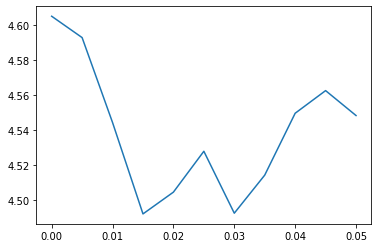

In [12]:
#SpotPrice dans un modèle de Heston
K=90
X0=np.log(100)
V0=0.04
theta=0.04
kappa=2
sigma=0.5
r=0.03
rho=-0.7
T=0.5
N=10
times=[0]
spotPrices = heston(X0,V0,r,kappa,theta,sigma,rho,T,N)
t=np.linspace(0,T/N,N+1)
plt.plot(t,spotPrices)

In [13]:
def payOffCall(price,K):
    return np.maximum(price-K,0)

In [14]:
#Building the prices sample
def priceCallByMC(K,X0,V0,r,kappa,theta,sigma,rho,T,N):
    sample=[]
    size = 10000
    for i in range(1,size+1):
        spotPrices = heston(X0,V0,r,kappa,theta,sigma,rho,T,N)
        sample.append(payOffCall(np.exp(spotPrices[-1]),K))
    return monteCarlo(sample,r,T)



In [15]:
beginTime = datetime.datetime.now()
price=priceCallByMC(K,X0,V0,r,kappa,theta,sigma,rho,T,N)
print("price for MonteCarlo gives",price)
endTime=datetime.datetime.now()
diff=endTime-beginTime
print("pricing via montecarlo with dim 100*10000 takes",diff.seconds, "seconds")

price for MonteCarlo gives 13.263200073469354
pricing via montecarlo with dim 100*10000 takes 2 seconds


# Generation mixing Fourier and MC

In [33]:
def priceIt(k,kappa,alpha,r,theta,sig,p,S0,V0,t,L):
    tmp = callPrice(k,kappa,alpha,r,theta,sig,p,S0,V0,t,L)
    if(np.isnan(tmp) or tmp.real < 0):
        X0 = np.log(S0)
        K = cmath.exp(k)
        tmpPrime = priceCallByMC(K,X0,V0,r,kappa,theta,sig,p,t,N)
        return tmpPrime.real
    return tmp.real
    

In [34]:
beginTime = datetime.datetime.now()
price=priceIt(k,kappa,alpha,r,theta,sig,p,S0,V0,t,L)
print("price for MonteCarlo gives",price)
endTime=datetime.datetime.now()
diff=endTime-beginTime
print("pricing via both  takes",diff.seconds, "seconds")

price for MonteCarlo gives 13.20248908466799
pricing via both  takes 0 seconds


In [37]:
beginTime = datetime.datetime.now()
size_=50000
#generating log strikes k
kLogList = [np.log((n*200)) for n in np.random.random(size=size_)]

#generating initial price S0
S0List =[n*200 for n in np.random.random(size=size_)]

#generating long run average price variance theta
thetaList = [n*5/10 for n in np.random.random(size=size_)]

#generating initial instantaneous variance V0
V0List = [n*5/10 + 0.05 for n in np.random.random(size=size_)]

#generating volatility sig
sigList=[n*5/10 for n in np.random.random(size=size_)]

#generating correlation rho
rhoList = [-n*0.95 for n in np.random.random(size=size_)]

#generating risk free rate r
rList = [n/10 for n in np.random.random(size=size_)]

#generating reversion speed kappa
kappaList = [n*2 for n in np.random.random(size=size_)]

#generating time to maturity tau
tauList=[n*1.4+1 for n in np.random.random(size=size_)]

#computing related prices
callPriceList = [priceIt(k,kappa,alpha,r,theta,sig,p,S0,V0,t,L).real for k,kappa,r,theta,sig,p,S0,V0,t in zip(kLogList,kappaList,rList,thetaList,sigList,rhoList,S0List,V0List,tauList)]

endTime=datetime.datetime.now()
diff=endTime-beginTime
print("generating the dataframe takes",diff)

/home/taurus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  """


generating the dataframe takes 2:43:13.052328


In [39]:
beginTime = datetime.datetime.now()

data={'kLog' : kLogList, 
      'S0'  : S0List,
      'theta':thetaList,
      'V0'  : V0List,
      'sigma' : sigList,
      'rho' : rhoList,
      'r'  : rList,
      'kappa': kappaList,
      'tau':tauList,
      'callPrice':callPriceList
     }
data=pd.DataFrame(data)
data.to_csv(r'fourrierData.csv', index = False)

endTime=datetime.datetime.now()
diff=endTime-beginTime
print("exporting data to csv takes",diff)

exporting data to csv takes 0:00:00.722133


In [41]:
S0List

[6.85183008161927,
 116.67910374432438,
 142.49140168829254,
 91.54472516527892,
 111.73870447957295,
 52.37525332001205,
 115.47998989356685,
 10.319283084239084,
 26.96296114889405,
 150.476750478494,
 139.25238450490758,
 49.252881858244926,
 103.36997943560891,
 128.39574976107514,
 134.13550759989556,
 72.16050397458697,
 65.00080374550352,
 17.42232471229346,
 68.94078647937718,
 163.87142957865467,
 170.47108987659496,
 41.10702074805592,
 26.269301519619326,
 87.25769273764415,
 190.56212269072336,
 9.178254578757139,
 52.359395525032724,
 172.58691886776097,
 115.41996849836235,
 171.2873916873352,
 169.23441039248925,
 170.14017732016288,
 135.64626744207064,
 66.24422123237088,
 123.77676508310358,
 74.82076322804537,
 126.34427999371715,
 189.1161825409941,
 121.4742055188691,
 165.88016874982628,
 44.37442847569153,
 148.04117726647704,
 47.20791941816549,
 190.90870067630172,
 32.08273278325249,
 108.6686113392904,
 8.287179028482505,
 187.9087558359387,
 62.7383772756880

In [29]:
a=np.nan
np.isnan(a)

True